# 🔍 영화 리뷰 감정 분석하기
**"네이버 영화 탭의 리뷰 감정을 분석하는 프로그램 제작"**

#### 😶 목차

1. 데이터 준비
2. 데이터 로더 구성
3. 데이터 분석 및 가공
4. 모델링
5. 임베딩 레이어 분석
6. Word2Vec 임베딩을 활용한 성능 개선
7. 회고

---

## 1. 데이터 준비

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 읽기
train_data = pd.read_table('~/aiffel/aiffel_exploration/E7/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_exploration/E7/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


---

## 2. 데이터 로더 구성

- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 제거
- 사전 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
    train_data = train_data.dropna(how = 'any') # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # 단어 사전 만들기
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}    # {단어:숫자} 딕셔너리 생성
    
    # 단어사전 인덱스로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

# 데이터셋 생성
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print('train data : {}, test data : {}'.format(len(X_train), len(X_test)))

#인덱스:단어 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

train data : 146182, test data : 49157


In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 확인
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


---

## 데이터 분석 및 가공
- 적절한 문장 길이 확인하기
- padding 추가하기

In [4]:
total_data_text = list(X_train) + list(X_test)

# 텍스트 데이터 문장 길이의 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 계산
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) *100))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# padding으로 문장 길이 맞추기
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='pre',
                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [6]:
# 훈련용 데이터셋 중 40000건을 분리하여 validation set으로 사용
x_val = X_train[:40000]
y_val = y_train[:40000]

# validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


---

## 4. 모델링

- **LSTM:** RNN 중에서 가장 널리 쓰이는 모델. RNN은 텍스트 데이터를 다루는데 주로 사용되는 딥러닝 모델이다. 시퀀스 형태의 데이터 처리에 적합하며 이전 시점의 모든 입력 정보를 현재 상태에 반영

- **1-D CNN:** 문장 전체를 한꺼번에 한 방향으로 스캐닝하면서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식

- **GlobalMaxPooling1D:** 전체 문장 중 단 하나의 가장 중요한 단어를 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식

#### LSTM

In [7]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))  # LSTM state 벡터의 차원수
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 6s 15ms/step - loss: 0.6227 - accuracy: 0.6336 - val_loss: 0.3853 - val_accuracy: 0.8384
Epoch 2/5
208/208 [==============================] - 2s 11ms/step - loss: 0.3530 - accuracy: 0.8550 - val_loss: 0.3568 - val_accuracy: 0.8451
Epoch 3/5
208/208 [==============================] - 2s 11ms/step - loss: 0.3161 - accuracy: 0.8707 - val_loss: 0.3488 - val_accuracy: 0.8499
Epoch 4/5
208/208 [==============================] - 2s 11ms/step - loss: 0.2996 - accuracy: 0.8793 - val_loss: 0.3506 - val_accuracy: 0.8494
Epoch 5/5
208/208 [==============================] - 2s 11ms/step - loss: 0.2897 - accuracy: 0.8839 - val_loss: 0.3533 - val_accuracy: 0.8479


In [9]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 5s - loss: 0.3630 - accuracy: 0.8426
[0.3630110025405884, 0.8426063656806946]


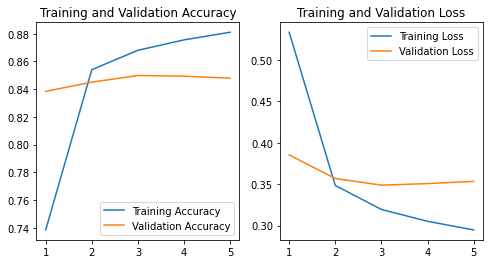

In [10]:
# 모델 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 1-D CNN

In [11]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 3, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
# 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 7s 20ms/step - loss: 0.6482 - accuracy: 0.6019 - val_loss: 0.4732 - val_accuracy: 0.7572
Epoch 2/5
208/208 [==============================] - 2s 8ms/step - loss: 0.4419 - accuracy: 0.7824 - val_loss: 0.4582 - val_accuracy: 0.7689
Epoch 3/5
208/208 [==============================] - 2s 8ms/step - loss: 0.4003 - accuracy: 0.8084 - val_loss: 0.4603 - val_accuracy: 0.7696
Epoch 4/5
208/208 [==============================] - 2s 7ms/step - loss: 0.3699 - accuracy: 0.8247 - val_loss: 0.4718 - val_accuracy: 0.7628
Epoch 5/5
208/208 [==============================] - 2s 8ms/step - loss: 0.3400 - accuracy: 0.8423 - val_loss: 0.4888 - val_accuracy: 0.7654


In [13]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 0.4922 - accuracy: 0.7666
[0.49216142296791077, 0.7665846347808838]


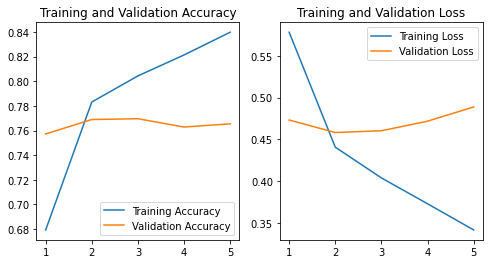

In [14]:
# 모델 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### GlobalMaxPooling1D

In [15]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 2s 6ms/step - loss: 0.6720 - accuracy: 0.6418 - val_loss: 0.4876 - val_accuracy: 0.8123
Epoch 2/5
208/208 [==============================] - 1s 5ms/step - loss: 0.4339 - accuracy: 0.8269 - val_loss: 0.3714 - val_accuracy: 0.8357
Epoch 3/5
208/208 [==============================] - 1s 5ms/step - loss: 0.3382 - accuracy: 0.8577 - val_loss: 0.3554 - val_accuracy: 0.8432
Epoch 4/5
208/208 [==============================] - 1s 5ms/step - loss: 0.3070 - accuracy: 0.8738 - val_loss: 0.3525 - val_accuracy: 0.8464
Epoch 5/5
208/208 [==============================] - 1s 5ms/step - loss: 0.2849 - accuracy: 0.8830 - val_loss: 0.3551 - val_accuracy: 0.8454


In [17]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3655 - accuracy: 0.8414
[0.36554598808288574, 0.8413857817649841]


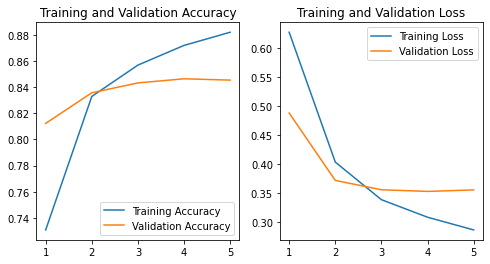

In [18]:
# 모델 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---

## 5. 임베딩 레이어 분석

In [19]:
#임베딩 레이어의 차원 확인
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [20]:
import os

# 학습한 Embedding 파라미터 저장하기
word2vec_file_path = os.getenv('HOME')+'/aiffel/aiffel_exploration/E7/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마의 사이즈로 할지 확인

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사한 단어와 그 유사도 확인1
word_vectors.similar_by_word("행복")

[('달달', 0.9537814855575562),
 ('짐캐리', 0.9426440000534058),
 ('어렷', 0.9353562593460083),
 ('을까요', 0.9134608507156372),
 ('는다는', 0.9084235429763794),
 ('편견', 0.9060893654823303),
 ('정치인', 0.8930906057357788),
 ('자주', 0.8868786096572876),
 ('오랜', 0.8840365409851074),
 ('또래', 0.8839032649993896)]

In [22]:
# 유사한 단어와 그 유사도 확인2
word_vectors.similar_by_word("공부")

[('킬', 0.8932152986526489),
 ('피노키오', 0.8810685276985168),
 ('봉태규', 0.8478336334228516),
 ('욕먹', 0.8411190509796143),
 ('일수록', 0.8385322093963623),
 ('ㅉㅉㅉ', 0.8288392424583435),
 ('...............', 0.8231907486915588),
 ('공략', 0.8107746839523315),
 ('미달', 0.810315728187561),
 ('젠장', 0.8096886277198792)]

---

## 6. Word2Vec 임베딩을 활용한 성능 개선
- 위의 결과를 통해 추가적인 성능 개선이 절실함을 확인..😥
- Pre-trained word vectors of 30+ languages 한국어 데이터 활용
- 버전 다운그레이드 필요 (pip install --upgrade gensim==3.8.3)

In [23]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/aiffel_exploration/E7/data/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [24]:
# 유사한 단어와 그 유사도 확인1
word2vec.wv.most_similar("행복")

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [25]:
# 유사한 단어와 그 유사도 확인2
word2vec.wv.most_similar("공부")

[('가르치', 0.6655912399291992),
 ('중퇴', 0.6448310613632202),
 ('수학', 0.6283489465713501),
 ('졸업', 0.5976732969284058),
 ('한학', 0.5947862267494202),
 ('수료', 0.5928074717521667),
 ('영문학', 0.5868287086486816),
 ('전공', 0.5848740339279175),
 ('배우', 0.5693216919898987),
 ('강론', 0.5641564726829529)]

#### 새로운 모델 생성(LSTM, pre)

In [26]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 차례대로 카피
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [27]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128)) # LSTM state 벡터의 차원 수 확대
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
1660/1660 [==============================] - 35s 20ms/step - loss: 0.4587 - accuracy: 0.7767 - val_loss: 0.3272 - val_accuracy: 0.8588
Epoch 2/5
1660/1660 [==============================] - 33s 20ms/step - loss: 0.2885 - accuracy: 0.8792 - val_loss: 0.3086 - val_accuracy: 0.8672
Epoch 3/5
1660/1660 [==============================] - 29s 18ms/step - loss: 0.2379 - accuracy: 0.9016 - val_loss: 0.3332 - val_accuracy: 0.8612
Epoch 4/5
1660/1660 [==============================] - 28s 17ms/step - loss: 0.1925 - accuracy: 0.9228 - val_loss: 0.3480 - val_accuracy: 0.8651
Epoch 5/5
1660/1660 [==============================] - 30s 18ms/step - loss: 0.1541 - accuracy: 0.9400 - val_loss: 0.3665 - val_accuracy: 0.8645


In [29]:
# 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)   # 정확도 향상

1537/1537 - 6s - loss: 0.3701 - accuracy: 0.8630
[0.3701492249965668, 0.862969696521759]


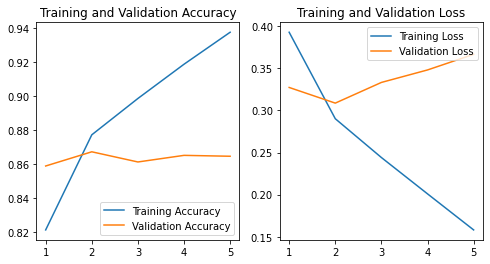

In [30]:
# 모델 시각화
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

---

## 7. 회고

1. **다양한 형태의 모델링 시도**
- LSTM, 1-D CNN, GlobalMAxPooling1D로 모델링을 진행해 보았으며, 정확도는 각각 0.8426, 0.7666, 0.8630 이었다.

2. **한국어 Word2Vec 적용 전후비교**
- **한국어 Word2Vec 적용 전**
 - **행복:** 달달, 짐캐리, 어렷, 을까요, 는다는, 편견, 정치인, 자주, 오랜, 또래
 - **공부:** 킬, 피노키오, 봉태규, 욕먹, 일수록, ㅉㅉㅉ, .........., 공략, 미달, 젠장

- **한국어 Word2Vec 적용 후**
 - **행복:** 사랑, 기쁨, 즐거움, 삶, 젊음, 즐겁, 인생, 존엄, 고독, 불행
 - **공부:** 가르치, 중퇴, 수학, 졸업, 한학, 수료, 영문학, 전공, 배우, 강론

3. **정확도**
- 한국어 Word2Vec를 이용해 정확도를 0.8426 -> 0.8630으로 향상시킬 수 있었다.
- 수치적인 정확도 개선은 1% 정도이지만 결과를 봤을 때 한국어 Word2Vec 적용만으로 엄청나게 발전된 모습을 보여줌을 알 수 있다.